# 4 RNN

## 4.1 Counting Bits

### 4.1.1 Task 1 : Dataset

In [26]:
import torch

In [27]:
num_samples = 100000
min_length = 1
max_length = 16

torch.manual_seed(42)
sequences = []
labels = []

for _ in range(num_samples):
    length = torch.randint(min_length, max_length + 1, (1,)).item()
    sequence = torch.randint(0, 2, (length,)).tolist()
    count_ones = sum(sequence)
    sequences.append(sequence)
    labels.append(count_ones)

In [28]:
train_size = int(num_samples * 0.8)
val_size = int(num_samples * 0.1)
test_size = num_samples - train_size - val_size

train_sequences, train_labels = sequences[:train_size], labels[:train_size]
val_sequences, val_labels = sequences[train_size:train_size + val_size], labels[train_size:train_size + val_size]
test_sequences, test_labels = sequences[train_size + val_size:], labels[train_size + val_size:]

In [29]:
train_examples = [(train_sequences[i], train_labels[i]) for i in range(5)]
train_examples

[([1, 0, 0, 0, 1, 0, 0], 2),
 ([1, 0, 0, 0, 0, 1, 0], 2),
 ([1, 1, 0, 1], 3),
 ([1, 1, 1, 1, 1], 5),
 ([1, 1], 2)]

### 4.1.2 Task 2 : Architecture

In [30]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [31]:
class CharLevelRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, dropout=0.0):
        super(CharLevelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed_x, h0)

        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        out = out[range(out.size(0)), lengths - 1]

        out = self.fc(out)
        return out


In [32]:
model = CharLevelRNN(input_size=1, hidden_size=32, num_layers=2, dropout=0.1)

### 4.1.3 Task 3 : Training

In [33]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [34]:
class BinarySequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32).unsqueeze(-1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sequence, label

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels

In [35]:
train_dataset = BinarySequenceDataset(train_sequences, train_labels)
val_dataset = BinarySequenceDataset(val_sequences, val_labels)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        lengths = torch.tensor([len(seq) for seq in sequences]).cpu().to(torch.int64)

        outputs = model(sequences, lengths).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            lengths = torch.tensor([len(seq) for seq in sequences]).cpu().to(torch.int64)
            outputs = model(sequences, lengths).squeeze()

            val_loss += criterion(outputs, labels).item()
            val_mae += torch.mean(torch.abs(outputs - labels)).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")


Epoch 1/10, Train Loss: 0.7544, Validation Loss: 0.0191, Validation MAE: 0.0932
Epoch 2/10, Train Loss: 0.0314, Validation Loss: 0.0026, Validation MAE: 0.0336
Epoch 3/10, Train Loss: 0.0233, Validation Loss: 0.0017, Validation MAE: 0.0289
Epoch 4/10, Train Loss: 0.0203, Validation Loss: 0.0010, Validation MAE: 0.0243
Epoch 5/10, Train Loss: 0.0177, Validation Loss: 0.0055, Validation MAE: 0.0678
Epoch 6/10, Train Loss: 0.0154, Validation Loss: 0.0019, Validation MAE: 0.0306
Epoch 7/10, Train Loss: 0.0139, Validation Loss: 0.0018, Validation MAE: 0.0355
Epoch 8/10, Train Loss: 0.0127, Validation Loss: 0.0020, Validation MAE: 0.0373
Epoch 9/10, Train Loss: 0.0124, Validation Loss: 0.0010, Validation MAE: 0.0262
Epoch 10/10, Train Loss: 0.0115, Validation Loss: 0.0018, Validation MAE: 0.0326


In [38]:
def random_baseline(val_loader):
    random_mae = 0.0

    with torch.no_grad():
        for sequences, labels in val_loader:
            batch_size = len(labels)
            sequence_lengths = [len(seq) for seq in sequences]
            random_predictions = torch.tensor(
                [torch.randint(0, seq_len + 1, (1,)).item() for seq_len in sequence_lengths],
                dtype=torch.float32
            )
            random_mae += torch.mean(torch.abs(random_predictions - labels)).item()

    random_mae /= len(val_loader)
    print(f"Random Baseline MAE: {random_mae:.4f}")

random_baseline(val_loader)


Random Baseline MAE: 5.5174


### 4.1.4 Task 4 : Generalization

In [39]:
start_length = 17
end_length = 32
num_samples = 100

ood_sequences = []
ood_labels = []

for length in range(start_length, end_length + 1):
    for _ in range(num_samples):
        seq = torch.randint(0, 2, (length, 1), dtype=torch.float32)
        label = seq.sum().item()
        ood_sequences.append(seq)
        ood_labels.append(label)

In [40]:
model.eval()
length_maes = []

with torch.no_grad():
    for length in range(17, 33):
        length_sequences = [seq for seq in ood_sequences if len(seq) == length]
        length_labels = [ood_labels[i] for i, seq in enumerate(ood_sequences) if len(seq) == length]

        sequences_batch = pad_sequence(length_sequences, batch_first=True).to(device)
        labels_batch = torch.tensor(length_labels, dtype=torch.float32).to(device)

        lengths = torch.tensor([len(seq) for seq in length_sequences]).cpu().to(torch.int64)

        predictions = model(sequences_batch, lengths).squeeze()

        mae = torch.mean(torch.abs(predictions - labels_batch)).item()
        length_maes.append(mae)

ood_maes = length_maes


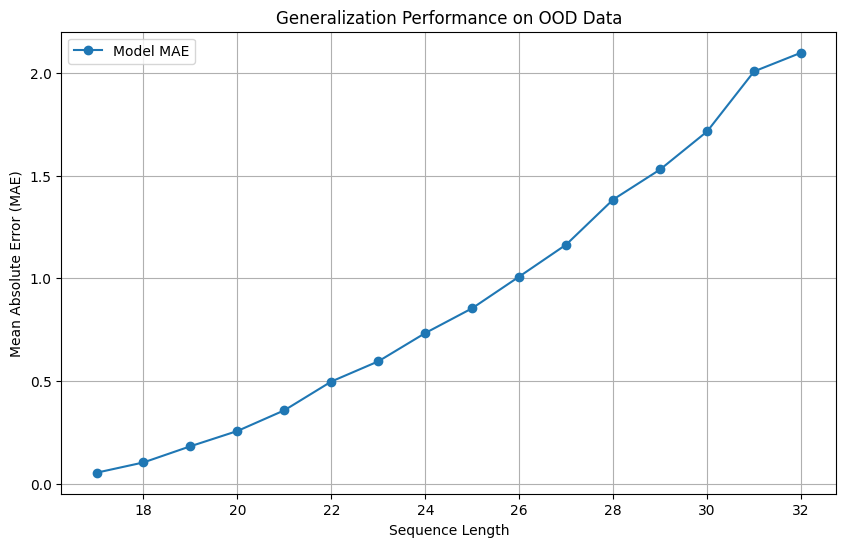

In [ ]:
import matplotlib.pyplot as plt

sequence_lengths = list(range(17, 33))
plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, ood_maes, marker="o", label="Model MAE")
plt.xlabel("Sequence Length")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Generalization Performance on OOD Data")
plt.legend()
plt.grid()
plt.show()


The model performs well on sequence lengths close to the training range (e.g., 17-20), but its performance degrade as sequence lengths increase, highlighting its limits in generalizing.

The model’s performance on unseen sequence lengths depends on its architecture and the range of data it was trained on. As its trained only on shorter sequences, the model may struggle with longer ones. More diverse training data and a robust architecture could improve generalization.

## 4.2 Optical Character Recognition

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import nltk
from nltk.corpus import words
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 4.2.1 Task 1 : Dataset

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /home/bharath/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
word_list = words.words()

unique_letters = set()

for word in word_list:
    unique_letters.update(set(word))

print("Unique letters:", sorted(unique_letters))

Unique letters: ['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
class Vocabulary:
    def __init__(self, unique_letters):
        self.char2idx = {char: idx + 1 for idx, char in enumerate(sorted(unique_letters))}
        self.char2idx["<PAD>"] = 0
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode(self, word):
        return [self.char2idx[char] for char in word]

    def decode(self, indices):
        return ''.join(self.idx2char[idx] for idx in indices if idx != 0)

vocab = Vocabulary(unique_letters)

print(f"Vocabulary size: {len(vocab.char2idx)}")


Vocabulary size: 54


In [ ]:
class WordImageDataset(Dataset):
    def __init__(self, num_samples=100000, image_size=(256, 64)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.word_list = words.words()
        self.font = ImageFont.load_default()

        self.max_length = max(len(word) for word in self.word_list)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        word = random.choice(self.word_list)
        encoded_word = vocab.encode(word)
        padded_word = encoded_word + [0] * (self.max_length - len(encoded_word))
        label = torch.tensor(padded_word, dtype=torch.long).to(device)

        image = Image.new('RGB', self.image_size, color='white')
        draw = ImageDraw.Draw(image)
        bbox = draw.textbbox((0, 0), word, font=self.font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        draw.text(((self.image_size[0] - text_width) / 2, (self.image_size[1] - text_height) / 2),
                  word, fill='black', font=self.font)

        image = np.array(image)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).to(device) / 255.0
        return image, label


In [ ]:

dataset = WordImageDataset()
print(f"Max word length in dataset: {dataset.max_length}")

Max word length in dataset: 24


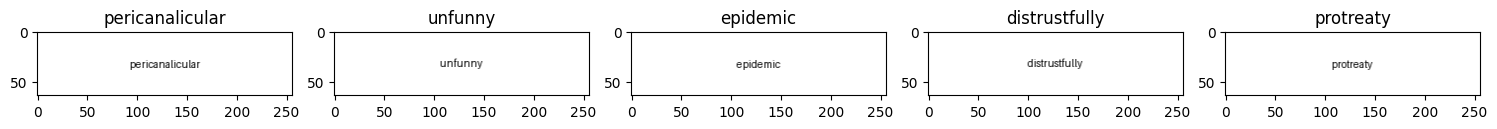

In [ ]:
num_examples = 5
plt.figure(figsize=(15, 5))

for i in range(num_examples):
    image, word = dataset[i]
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    decoded_word = vocab.decode(word.cpu().numpy())
    plt.title(decoded_word, fontsize=12)
    # plt.axis('off')

plt.tight_layout()
plt.show()


### 4.2.2 Task 2 : Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        return self.conv(x)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [ ]:
class Model(nn.Module):
    def __init__(self, cnn, rnn, max_length):
        super(Model, self).__init__()
        self.cnn = cnn
        self.rnn = rnn
        self.max_length = max_length

    def forward(self, x):
        features = self.cnn(x)
        batch_size, channels, height, width = features.size()
        if width > self.max_length:
            features = features[:, :, :, :self.max_length]
        elif width < self.max_length:
            padding = self.max_length - width
            features = F.pad(features, (0, padding))

        features = features.permute(0, 3, 1, 2).contiguous()
        features = features.view(batch_size, self.max_length, -1)

        output = self.rnn(features)
        return output



In [ ]:
max_length = dataset.max_length
cnn = CNN().to(device)
rnn = RNN(input_size=512, hidden_size=128, vocab_size=len(vocab.char2idx)).to(device)
model = Model(cnn, rnn, max_length).to(device)

### 4.2.3 Task 3 : Training

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
def character_accuracy(preds, targets):
    correct = 0
    total = 0
    for pred, target in zip(preds, targets):
        correct += sum(p == t for p, t in zip(pred, target))
        total += len(target)
    return correct / total

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(0, 2, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 2, 1)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=2).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(labels.cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = character_accuracy(all_preds, all_targets)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [1/10], Train Loss: 1.3901, Val Loss: 1.3620, Val Accuracy: 0.6027
Epoch [2/10], Train Loss: 1.3673, Val Loss: 1.3855, Val Accuracy: 0.6019
Epoch [3/10], Train Loss: 1.3664, Val Loss: 1.4948, Val Accuracy: 0.6015
Epoch [4/10], Train Loss: 1.3640, Val Loss: 1.3712, Val Accuracy: 0.6025
Epoch [5/10], Train Loss: 1.3629, Val Loss: 1.3799, Val Accuracy: 0.6001
Epoch [6/10], Train Loss: 1.3650, Val Loss: 1.3911, Val Accuracy: 0.6023
Epoch [7/10], Train Loss: 1.3656, Val Loss: 2.0164, Val Accuracy: 0.6028
Epoch [8/10], Train Loss: 1.3647, Val Loss: 1.5707, Val Accuracy: 0.6001
Epoch [9/10], Train Loss: 1.3642, Val Loss: 1.4547, Val Accuracy: 0.6023
Epoch [10/10], Train Loss: 1.3620, Val Loss: 2.8134, Val Accuracy: 0.6019
